# EDA and Models for Sentiment Analysis

In this notebook we will do some data analysis with the sentiment dataset we put together.
Furthermore we will use some machine learning models to try and classify the data.

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from time import time

# Add custom functions path
sys.path.append('../Functions')

In [2]:
# Import data with custom function so the classes are balanced
from datasets import load_stratified_dataset
df = load_stratified_dataset(path='../Datasets/full_good_bad_dataset.csv', labels='label', samples_per_label=2854)

# Did it work?
df.label.value_counts()

1    2854
0    2853
Name: label, dtype: int64

## EDA
We start by doing some analysis of our data.

***
- label: 1 = good sentiment; 0 = bad or neutral sentiment
- source: the website the articles were scraped from
- text: the complete article text
- title: the news headline
- url: the original link to the article
- text_lem: preprocessed text without stopwords etc.
***

In [3]:
# Overview
df.head()

,label,source,text,title,url,text_lem
0,1,UpliftingNews,Related story: Man's Proposal To His Girlfrien...,Woman Gives Her Boyfriend An ‘Out’ After Getti...,viralmag,relate story man proposal girlfriend kfc go vi...
1,1,good_news_network,Andres Amador spends a lot of time on beaches ...,Man Uses Rake to Create Huge Murals in the Sho...,goodnewsnetwork,andres amador spend lot time beach create artw...
2,1,webhose.io,Yokohama extends hospitality to convention del...,Yokohama extends hospitality to convention del...,NaN,yokohama extend hospitality convention delegat...
3,1,webhose.io,Great Aussie Bake Off returns to the kitchen a...,Great Aussie Bake Off returns to the kitchen a...,NaN,great aussie bake return kitchen screen seanna...
4,0,webhose.io,William Shatner slams George Takei 13th Oct 20...,William Shatner slams George Takei,NaN,william shatner slams george takei 13th oct 20...


***
#### Domains
Let's first look at the different domains we have in this dataset.
***

In [4]:
# Count unknown article source and drop those
url_list = df.url
print(f'The source domain is unknown for {df.url.isnull().sum()} articles')
url_list = url_list.dropna();

The source domain is unknown for 2305 articles


In [5]:
# Count the number of times the domain appears
values, counts = np.unique(url_list, return_counts=True)
df_url = {'url' : values, 'count' : counts}
df_url = pd.DataFrame(data=df_url)

# Sort by counts
df_url_sorted = df_url.sort_values('count', ascending=False)

# Print result
print(df_url.sort_values('count', ascending=False)[0:10])
print('--------')
print(f'There are at least {df_url.url.nunique()} unique domains in this dataset')

                 url  count
223  goodnewsnetwork    706
49               bbc    206
565       thejournal    169
558      theguardian    161
109              cnn    113
439         positive    111
464          reuters    105
256      independent     89
371          nbcnews     39
405          nytimes     39
--------
There are at least 684 unique domains in this dataset


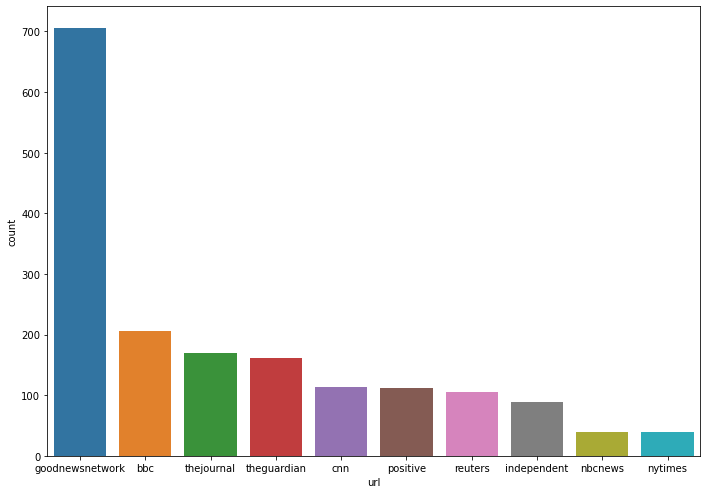

In [6]:
# Show top 10 domains
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
ax = sns.barplot(x="url", y="count", data=df_url_sorted[0:10])

***
'goodnewsnetwork' is one of the scraped websites for positive news. In contrast to other similar sites, they write all of their articles and don't link to external sources. 
Thus it was expected that they would be one of the most frequent sites to find in our dataset.
'Positive' and 'thejournal' are also scraped sites for positive news, where they write some articles themselves.
***

In [7]:
# Drop specifically scraped sites
df_url_sorted = df_url_sorted.drop(df_url_sorted[df_url_sorted.url == 'goodnewsnetwork'].index)
df_url_sorted = df_url_sorted.drop(df_url_sorted[df_url_sorted.url == 'positive'].index)
df_url_sorted = df_url_sorted.drop(df_url_sorted[df_url_sorted.url == 'thejournal'].index)

The top 10 domains contribute at least 860 articles to the dataset


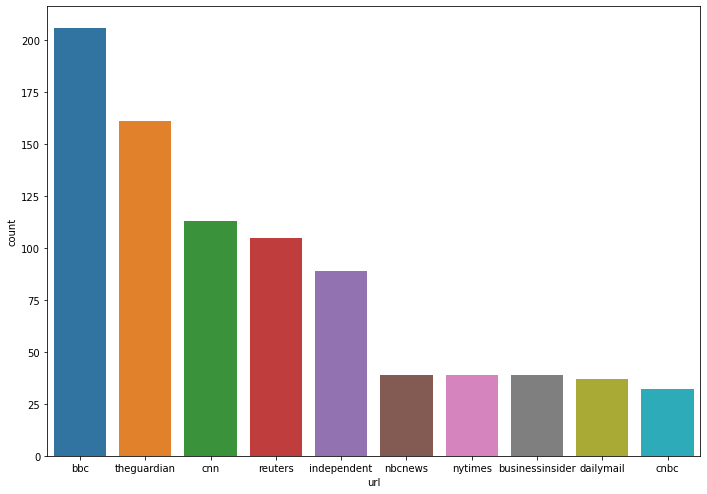

In [8]:
# Show top 10 again
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
ax = sns.barplot(x="url", y="count", data=df_url_sorted[0:10])
print(f'The top 10 domains contribute at least {df_url_sorted["count"][0:10].sum()} articles to the dataset')

***
These kind of distributions can always influence our machine learning models, as the domains all differ in writing style and website design. Let's keep this in mind for further analysis and later on.
***

#### Word influence on good and bad/neutral news
Next up we will analyse the word distribution

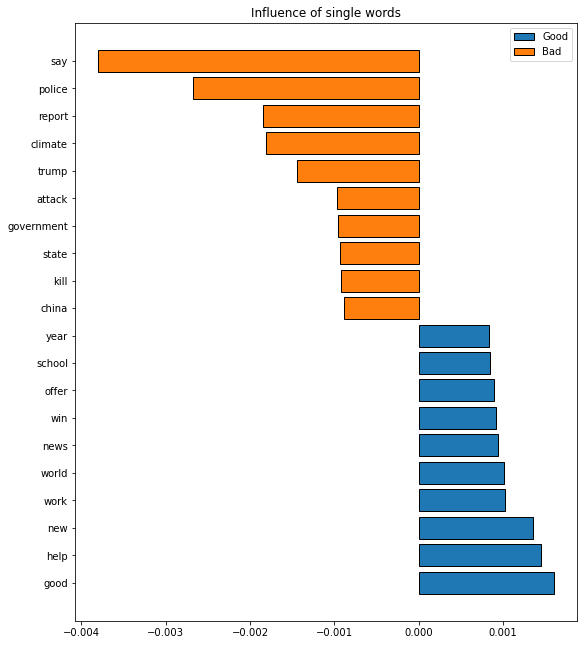

In [9]:
# Import libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize words by their number of appearance
vect = CountVectorizer()
X = vect.fit_transform(df.text_lem)
words = vect.get_feature_names()

# Define label
y = df['label'].values

# Remove alpha to prevent bias
clf = MultinomialNB(alpha=1.e-10)
clf.fit(X,y)

# Create Dataframe for probability
likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['negative', 'positive'], index=words)
likelihood_df['Influence'] = likelihood_df.eval('(exp(positive) - exp(negative))')
top_10 = likelihood_df['Influence'].sort_values(ascending=False)[:10]

# Double-sorting here so that the graph will look nicer
bottom_10 = likelihood_df['Influence'].sort_values()[:10].sort_values(ascending=False)
top_and_bottom = pd.concat([top_10,bottom_10])

# Plot
x = range(10)
fig = plt.figure(figsize=(9,11))
ax = plt.subplot(111)
ax.barh(top_10.index, top_10, edgecolor='black')
ax.barh(bottom_10.index, bottom_10, edgecolor='black');
ax.set_title('Influence of single words');
ax.legend(['Good', 'Bad/Neutral']);

***
The influence of bad/neutral words seems to be greater than that of good words. Also the word 'say' seems to appear a lot more in bad/neutral labeled articles than in good ones, which is kind of interesting.
Most of the words make quite a bit of sense. 
'com' in the good category 

***

## Models

In [10]:
# Importing the auxiliary and preprocessing libraries 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Import Models
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Set random_state
random_state = 69

In [11]:
# Create models
models = []
models.append(("LogReg", LogisticRegression(n_jobs=-1, random_state=random_state)))            
models.append(("NaiveBayes", MultinomialNB()))
models.append(("XGBClassifier", XGBClassifier(n_jobs=-1, random_state=random_state)))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier(random_state=random_state)))
models.append(("RandomForestClassifier", RandomForestClassifier(n_jobs=-1, random_state=random_state)))
models.append(("GradientBoostingClassifier", GradientBoostingClassifier(random_state=random_state)))
models.append(("RidgeClassifier", RidgeClassifier(random_state=random_state)))
models.append(("BaggingRidgeClassifier", BaggingClassifier(n_jobs=-1, random_state=random_state)))
models.append(("ExtraTreesClassifier", ExtraTreesClassifier(n_jobs=-1, random_state=random_state)))
models.append(("LinearSVC", LinearSVC(random_state=random_state)))

In [12]:
# Split the data into train, test and validation set
X = df['text_lem'] # already preprocessed
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.15, random_state=random_state)

In [72]:
# Vectorize the data
tfidf = TfidfVectorizer()

# Fit the transformer
tfidf_fit = tfidf.fit(X_train)

# Transform all splits
X_train_tfidf = tfidf_fit.transform(X_train)
X_test_tfidf = tfidf_fit.transform(X_test)
X_val_tfidf = tfidf_fit.transform(X_val)

# Save the fitted transformer
pickle.dump(tfidf_fit, open("tfidf.pickle", "wb"))

In [46]:
# Print shapes of the splits
print(f'Shape train: {X_train.shape[0]} rows')
print(f'Shape test: {X_test.shape[0]} rows')
print(f'Shape val: {X_val.shape[0]} rows')

Shape train: 3638 rows
Shape test: 1427 rows
Shape val: 642 rows


In [47]:
# Create a Dataframe for the model results
model_results = pd.DataFrame(columns=['name', 'result', 'runtime'])

In [48]:
# Run the models, save and print the results
for name, model  in models:
    start = time()
    cv_results = cross_val_score(model, X_train_tfidf, y_train, 
                                 cv= 5, scoring='accuracy',
                                 n_jobs=-1)
    end = time()
    runtime = end-start
    results_df = pd.DataFrame([[name, cv_results.mean(), runtime]], columns=['name', 'result', 'runtime'])
    model_results = model_results.append(results_df)
    print(f'{name}: {cv_results.mean().round(4)} (+/-{cv_results.std().round(4)})')

LogReg: 0.8546 (+/-0.0137)
NaiveBayes: 0.8378 (+/-0.0136)
XGBClassifier: 0.8139 (+/-0.0149)
DecisionTreeClassifier: 0.6839 (+/-0.0089)
RandomForestClassifier: 0.8348 (+/-0.016)
GradientBoostingClassifier: 0.8186 (+/-0.0183)
RidgeClassifier: 0.8576 (+/-0.0098)
BaggingRidgeClassifier: 0.7694 (+/-0.0209)
ExtraTreesClassifier: 0.8436 (+/-0.0107)
LinearSVC: 0.8565 (+/-0.0113)


In [17]:
# Set index and display results dataframe
model_results.set_index(pd.Index(list(range(0, model_results.shape[0]))), inplace=True)
model_results

,name,result,runtime
0,LogReg,0.854322,4.353772
1,NaiveBayes,0.830682,0.174318
2,XGBClassifier,0.808419,74.234441
3,DecisionTreeClassifier,0.686642,11.693481
4,RandomForestClassifier,0.840300,12.782195
5,GradientBoostingClassifier,0.817208,76.227036
6,RidgeClassifier,0.859539,0.384786
7,BaggingRidgeClassifier,0.765812,38.138979
8,ExtraTreesClassifier,0.844149,22.707623
9,LinearSVC,0.859266,0.405087


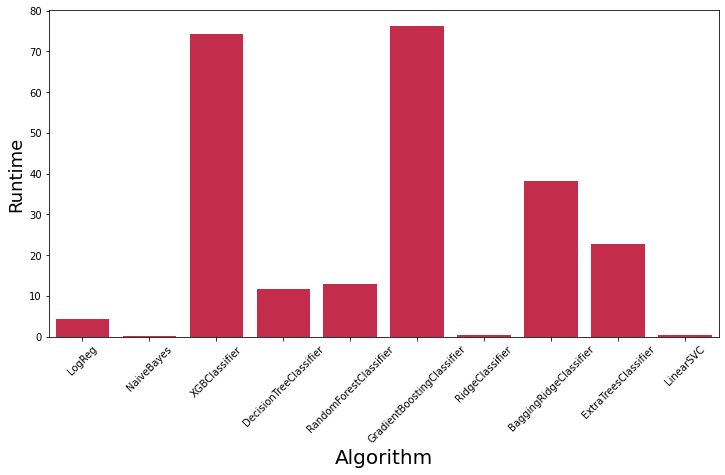

In [18]:
# Let's plot the runtime
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
ax = sns.barplot(x="name", y="runtime", data=model_results, color='crimson')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);
ax.set_xlabel("Algorithm", fontsize=20);
ax.set_ylabel("Runtime", fontsize=18)
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True

### Optimization

Let's use the top 5 models and try to tune their parameters for optimal performance

In [19]:
# Sort the 5 best models
model_results.sort_values(by=['result'], ascending=False)[0:5]

,name,result,runtime
6,RidgeClassifier,0.859539,0.384786
9,LinearSVC,0.859266,0.405087
0,LogReg,0.854322,4.353772
8,ExtraTreesClassifier,0.844149,22.707623
4,RandomForestClassifier,0.840300,12.782195


***
SVC, Ridge, LogReg, ExtraTrees and RandomForest/NaiveBayes usually give the best scores. Instead of the RandomForest, we will use the NaiveBayes to bring another sort of algorithm into our VotingClassifier in the end.
***

In [20]:
# Function to print the best parameters from Grid- or RandomizedSearch
def best_parameters(model_name):
    print('---------------')
    print('Best parameters')
    print('---------------')
    for pair in model_name.best_params_.items():
        print(f'{pair[0].capitalize()} : {pair[1]}')

#### RidgeClassifier

A RidgeClassifier can only be optimized by chaning its solving algorithm. In this case the 'auto' function already chose the best possible solver for our case, so further tuning is not needed.

In [21]:
# Use the model on the test and validation sets
rc = RidgeClassifier(random_state=random_state).fit(X_train_tfidf, y_train)
print(f"Mean Accuracy for train set : {(cross_val_score(rc, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for test set : {(rc.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(rc.score(X_val_tfidf, y_val)*100).round(2)}%")

Mean Accuracy for train set : 85.95%
Accuracy for test set : 86.76%
Accuracy for val set: 87.54%


#### Logistic Regression

The default algorithm is already quite good. We can take a look at what happens when we introduce a few different C-Scores.

In [22]:
lr = LogisticRegression(n_jobs=-1, random_state=random_state).fit(X_train_tfidf, y_train)
print(f"Cross validation accuray for train set : {(cross_val_score(lr, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(lr.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(lr.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(lr.score(X_val_tfidf, y_val)*100).round(2)}%")

Cross validation accuray for train set : 85.43%
Accuracy for train set : 93.98%
Accuracy for test set : 86.19%
Accuracy for val set: 88.47%


In [23]:
# Define parameters for GridSearch
params_lr = {'C' : [0.01, 0.025, 0.05, 0.1, 0.5, 1],
             'solver' : ['saga', 'sag', 'lbfgs']
            }

# Run GridSearchs
lr_search = GridSearchCV(lr, params_lr, cv=5, n_jobs=-1, verbose=1)
lr_search.fit(X_train_tfidf, y_train)

# Print the best parameters
best_parameters(lr_search)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.3s finished


---------------
Best parameters
---------------
C : 1
Solver : saga


***
C = 1 is the default value. We will therefore see no change in the outcome. Since the algorithm is not yet overfitting we can leave it at that.
Let's use the 2 params and prove our hypothesis.
***

In [24]:
# Get best model
lr_best = lr_search.best_estimator_

# Fit on the data
lr_best.fit(X_train_tfidf, y_train)

# Print results
print(f"Cross validation for train set : {(cross_val_score(lr_best, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(lr_best.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(lr_best.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(lr_best.score(X_val_tfidf, y_val)*100).round(2)}%")

Cross validation for train set : 85.46%
Accuracy for train set : 94.04%
Accuracy for test set : 86.19%
Accuracy for val set: 88.47%


#### Extra-trees classifier

In [25]:
# Define model and fit
et = ExtraTreesClassifier(n_jobs=-1, random_state=random_state).fit(X_train_tfidf, y_train)

# Print results
print(f"Cross validation accuray for train set : {(cross_val_score(et, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(et.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(et.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(et.score(X_val_tfidf, y_val)*100).round(2)}%")

Cross validation accuray for train set : 84.41%
Accuracy for train set : 99.89%
Accuracy for test set : 85.49%
Accuracy for val set: 88.16%


***
The Classifier is overfitting with nearly 100% on the trainset. We will need to tune it down.
***

In [26]:
# Define parameters for RandomizedSearch
params_et = {'max_depth' : np.linspace(10, 110, num = 11).tolist() + [None],
            'min_samples_split' : [5, 10, 15],
            'min_samples_leaf' : [10,15,20],
            'bootstrap' : [True, False],
            'max_leaf_nodes' : [50,100],
            'criterion' : ['gini', 'entropy']
            }

# Run GridSearch
et_search = RandomizedSearchCV(et, params_et, cv=5, n_jobs=-1, verbose=1, n_iter = 100)
et_search.fit(X_train_tfidf, y_train)

# Print the best parameters
best_parameters(et_search)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.3min finished


---------------
Best parameters
---------------
Min_samples_split : 5
Min_samples_leaf : 10
Max_leaf_nodes : 100
Max_depth : 80.0
Criterion : gini
Bootstrap : False


In [27]:
# Get best model
et_best = et_search.best_estimator_

# Fit on the data
et_best.fit(X_train_tfidf, y_train)

# Print results
print(f"Cross validation for train set : {(cross_val_score(et_best, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(et_best.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(et_best.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(et_best.score(X_val_tfidf, y_val)*100).round(2)}%")

Cross validation for train set : 82.93%
Accuracy for train set : 88.18%
Accuracy for test set : 84.09%
Accuracy for val set: 87.23%


***
Looking good. Let's see if we can make it even better.
***

In [28]:
# Define parameters for GridSearch
params_et = {'max_depth' : [45,50,55],
            'min_samples_split' : [5,10,15],
            'min_samples_leaf' : [5,10,15],
            'max_leaf_nodes' : [100,102,104],
            'criterion' : ['entropy']
            }

# Run GridSearch
et_search = GridSearchCV(et, params_et, cv=5, n_jobs=-1, verbose=1)
et_search.fit(X_train_tfidf, y_train)

# Print the best parameters
best_parameters(et_search)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  6.8min finished


---------------
Best parameters
---------------
Criterion : entropy
Max_depth : 50
Max_leaf_nodes : 102
Min_samples_leaf : 5
Min_samples_split : 15


In [29]:
# Get best model
et_best = et_search.best_estimator_

# Fit on the data
et_best.fit(X_train_tfidf, y_train)

# Print results
print(f"Cross validation for train set : {(cross_val_score(et_best, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(et_best.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(et_best.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(et_best.score(X_val_tfidf, y_val)*100).round(2)}%")

Cross validation for train set : 83.34%
Accuracy for train set : 90.27%
Accuracy for test set : 84.23%
Accuracy for val set: 86.76%


***
It became a tiny bit better. Let's stop here so it doesn't overfit.
***

#### NaiveBayes

In [30]:
# Define model and fit
nb = MultinomialNB().fit(X_train_tfidf, y_train)

# Print results
print(f"Cross validation accuray for train set : {(cross_val_score(nb, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(nb.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(nb.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(nb.score(X_val_tfidf, y_val)*100).round(2)}%")

Cross validation accuray for train set : 83.07%
Accuracy for train set : 91.12%
Accuracy for test set : 84.65%
Accuracy for val set: 87.07%


#### Linear SupportVectorClassifier

In [31]:
# Define model and fit
sv = LinearSVC(random_state=random_state).fit(X_train_tfidf, y_train)

# Print results
print(f"Cross validation accuray for train set : {(cross_val_score(nb, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(nb.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(nb.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(nb.score(X_val_tfidf, y_val)*100).round(2)}%")

Cross validation accuray for train set : 83.07%
Accuracy for train set : 91.12%
Accuracy for test set : 84.65%
Accuracy for val set: 87.07%


#### Voting Classifier

In [73]:
vc = VotingClassifier(estimators=[('sv', sv), ('rc', rc), ('lr', lr_best), ('et', et_best), ('nb', nb)], voting='hard')
vc.fit(X_train_tfidf, y_train)
y_pred = vc.predict(X_test_tfidf)
pickle.dump(vc, open("vc.pickle", "wb"))

In [74]:
print(f"Cross validation accuray for train set : {(cross_val_score(vc, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(vc.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(vc.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(vc.score(X_val_tfidf, y_val)*100).round(2)}%")

Cross validation accuray for train set : 85.95%
Accuracy for train set : 96.32%
Accuracy for test set : 86.9%
Accuracy for val set: 88.16%


In [36]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_pred, y_test))

[[631  82]
 [105 609]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       736
           1       0.85      0.88      0.87       691

    accuracy                           0.87      1427
   macro avg       0.87      0.87      0.87      1427
weighted avg       0.87      0.87      0.87      1427



In [161]:
wrong_pred = []
count = 0
for vect, prediction, label in zip(X_test_tfidf, y_pred, y_test):
    if prediction != label:
        wrong_pred.append(X_test.index[count])
    #print(label, prediction)
    count += 1

In [176]:
print(df.text.values[wrong_pred[2]])
print('------------')
print(df.text_lem.values[wrong_pred[2]])
print('------------')
print(df.label[wrong_pred[2]])
print('------------')
print(df.source[wrong_pred[2]])
print('------------')
print(df.url[wrong_pred[2]])

Image 1 of / 1 1 Elegiac fiction set in Central Texas 1 / 1 Back to Gallery In the tradition of Wendell Berry ’s elegiac fiction, Elizabeth Harris ’s Mayhem evokes the bygone era of 20th-century farming families intertwined with the land, the past and one another.
It’s a novel that shows reverence to the American South and the people who labored there, but, unlike Berry’s Port William, Kentucky, Harris’ Prince Carl County is unmistakably Central Texas, complete with cattle, cotton, pink granite courthouses and tight-knit German communities.
Against this rural Texas backdrop we bear witness to Evelyn Kunkle Gant ’s “Three Lives,” as Mayhem’s subtitle suggests.
More Information Mayhem: Three Lives of a Woman
By Elizabeth Harris
Gival Press, $20
Evelyn’s early upbringing in a respected German farming family transitions smoothly into her life as a young bride working the land with husband Les Gant . They are well-suited as a couple, but neither is equipped to deal with Evelyn’s sexual assa

In [177]:
test = tfidf_fit.transform([df.text_lem.values[wrong_pred[2]]])

In [178]:
vc.predict(test)

array([1])